Guia 5: Dominio Frecuencial

Ejercicio 5.3

In [1]:
from __future__ import division
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
cv

<module 'cv2' from 'c:\\Users\\ignac\\anaconda3\\envs\\pdi\\Lib\\site-packages\\cv2.cp311-win_amd64.pyd'>

In [2]:
def spectrum(img):
    """Calcula y muestra el módulo logartímico de la DFT de img."""
    
    imgf=cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT) 
    modulo = np.log(cv.magnitude(imgf[:,:,0],imgf[:,:,1])+1)
    modulo = np.fft.fftshift(modulo) 
    modulo=cv.normalize(modulo, modulo, 0, 1, cv.NORM_MINMAX)
    
    return modulo

def filterImg(img,filtro_magnitud):
    """Filtro para imágenes de un canal"""
    
    #como la fase del filtro es 0 la conversión de polar a cartesiano es directa (magnitud->x, fase->y)
    filtro=np.array([filtro_magnitud,np.zeros(filtro_magnitud.shape)]).swapaxes(0,2).swapaxes(0,1)
    imgf=cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
   
    imgf=cv.mulSpectrums(imgf, np.float32(filtro), cv.DFT_ROWS)
    
    return cv.idft(imgf, flags=cv.DFT_REAL_OUTPUT | cv.DFT_SCALE)

	
def filterButterworth(rows, cols, corte, order):
    """filtro de magnitud Butterworth"""
    #corte = w en imagen de lado 1
    #1 \over 1 + {D \over w}^{2n}
    magnitud = np.zeros((rows, cols))
    corte *= rows;
    for k in range(rows):
        for l in range(cols):
            d2 = dist([k+.5,l+.5],[rows/2,cols/2])
            magnitud[k,l] = 1.0/(1 + (d2/corte/corte)**order)

    return np.fft.fftshift(magnitud)


def dist(a,b):
    """distancia Euclidea"""
    return np.linalg.norm(np.array(a)-np.array(b))

E

In [3]:
def rotarImagen(imagen,angulo):
    h=imagen.shape[0]
    w=imagen.shape[1]
    center = (h // 2, w // 2)
    M = cv.getRotationMatrix2D(center, angulo, 1.0)
    rotated = cv.warpAffine(imagen, M, (w,h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT)
    return rotated


def rotate_to_angle(original_image, image_to_rotate):

    # Aplicar la transformada de Fourier a las imágenes
    fft_original = np.fft.fft2(original_image).astype(np.uint8)
    fft_to_rotate = np.fft.fft2(image_to_rotate).astype(np.uint8)

    # Calcular el espectro de potencia
    power_spectrum_original = np.abs(fft_original) ** 2
    power_spectrum_to_rotate = np.abs(fft_to_rotate) ** 2

    # Calcular la correlación cruzada entre los espectros de potencia
    cross_correlation = cv.matchTemplate(power_spectrum_original, power_spectrum_to_rotate, cv.TM_CCORR_NORMED)

    # Encontrar la posición del valor máximo en la matriz de correlación cruzada
    _, max_val, _, max_loc = cv.minMaxLoc(cross_correlation)

    # Calcular el desplazamiento en píxeles desde la posición central hasta la posición del valor máximo
    rows, cols = cross_correlation.shape
    displacement = np.array(max_loc) - np.array((cols // 2, rows // 2))

    # Calcular el ángulo de rotación correspondiente al desplazamiento
    angle = np.degrees(np.arctan2(displacement[1], displacement[0]))

    return angle


C:\Users\ignac\AppData\Local\Temp\ipykernel_15628\3805145129.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_original = np.fft.fft2(original_image).astype(np.uint8)
C:\Users\ignac\AppData\Local\Temp\ipykernel_15628\3805145129.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_to_rotate = np.fft.fft2(image_to_rotate).astype(np.uint8)


28.886581766910695


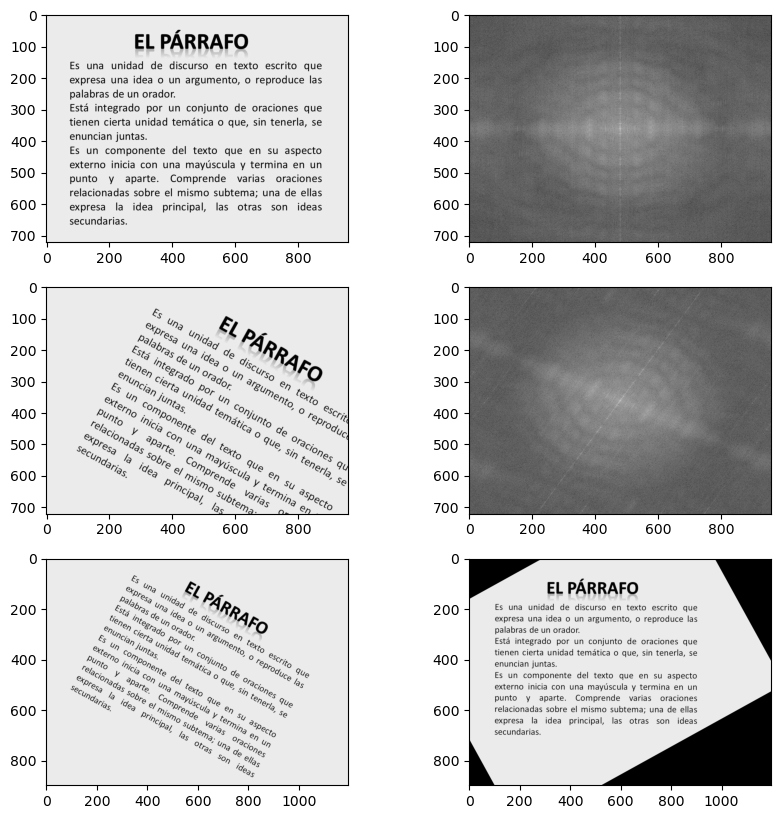

In [4]:
import math
imagen0 = cv.imread("IMAGENES/parrafo0.jpg",cv.IMREAD_GRAYSCALE)
imagen1 = cv.imread("IMAGENES/parrafo1.jpg",cv.IMREAD_GRAYSCALE)[0:720,0:960]
imagen2 = cv.imread("IMAGENES/parrafo1.jpg",cv.IMREAD_GRAYSCALE)



angulo = rotate_to_angle(imagen0,imagen2)

angulo = 180 + angulo
print(angulo)
# (h, w) = imagen2.shape[:2]
# center = (w // 2, h // 2)
# M = cv.getRotationMatrix2D(center, angulo, 1.0)
# rotated = cv.warpAffine(imagen2, M, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)


rotated = rotarImagen(imagen2,angulo)

fig,ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(imagen0,cmap="gray")
ax[0,1].imshow(spectrum(imagen0),cmap="gray")

ax[1,0].imshow(imagen1,cmap="gray")
ax[1,1].imshow(spectrum(imagen1),cmap="gray")

ax[2,0].imshow(imagen2,cmap="gray")
ax[2,1].imshow(rotated,cmap="gray")

plt.show()


GUIA 6: Restauracion

Ejercicio 3: Filtros de orden

In [5]:
def punto_medio(image, ksize):
    im_H, im_W = image.shape
    im_f_mch = np.zeros(image.shape)

    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)
    
    im_f_pm0 = np.zeros(image.shape)
    for i in range(im_H):
        for j in range(im_W):
            vMin, vMax = cv.minMaxLoc(im_p[i:i+ksize,j:j+ksize])[0:2]
            im_f_pm0[i, j] = (vMin+vMax)/2
    return im_f_pm0

def media_alfa(im, ksize):
    #aplica filtro media-alfa recortado
    #ksize = 3
    im_H, im_W = im.shape
    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(im), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)
    im_f_mar = np.zeros(im.shape)

    #0<=d<=mn-1, mn -> tamaño del "kernel"
    d = 8
    for i in range(im_H):
        for j in range(im_W):
            S = np.sort(im_p[i:i+ksize,j:j+ksize].flatten())
            S = S[d//2:S.shape[0]-d//2]
            im_f_mar[i, j] = np.sum(S)/S.shape[0]
    return im_f_mar

In [6]:
def impulsivo(val0,prob0,val1,prob1,val2,size):
    arr = np.zeros(size)
    n_ib = cv.randu(arr,0,1)
    for i in np.arange(size[0]):
        for j in np.arange(size[1]):
            if n_ib[i,j] <=prob0:
                n_ib[i,j] = val0
            elif n_ib[i,j]>prob0 and n_ib[i,j]<prob0+prob1:
                n_ib[i,j] = val1
            else:
                n_ib[i,j] = val2
    return n_ib

def mse(imageA, imageB): 
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) 
    err /= float(imageA.shape[0] * imageA.shape[1]) 
    return err

MSE Degradada (Gauss+Imp) - Limpia:  2535.3037791666666
MSE Filtrada (Median) - Limpia:  288.0705541666667
MSE Filtrada (PtoMedio) - Limpia:  1276.0800427083334
MSE Filtrada (MediaAlfa) - Limpia:  297.2955958333333
MSE Filtrada (Median + PtoMedio) - Limpia:  310.0237114583333


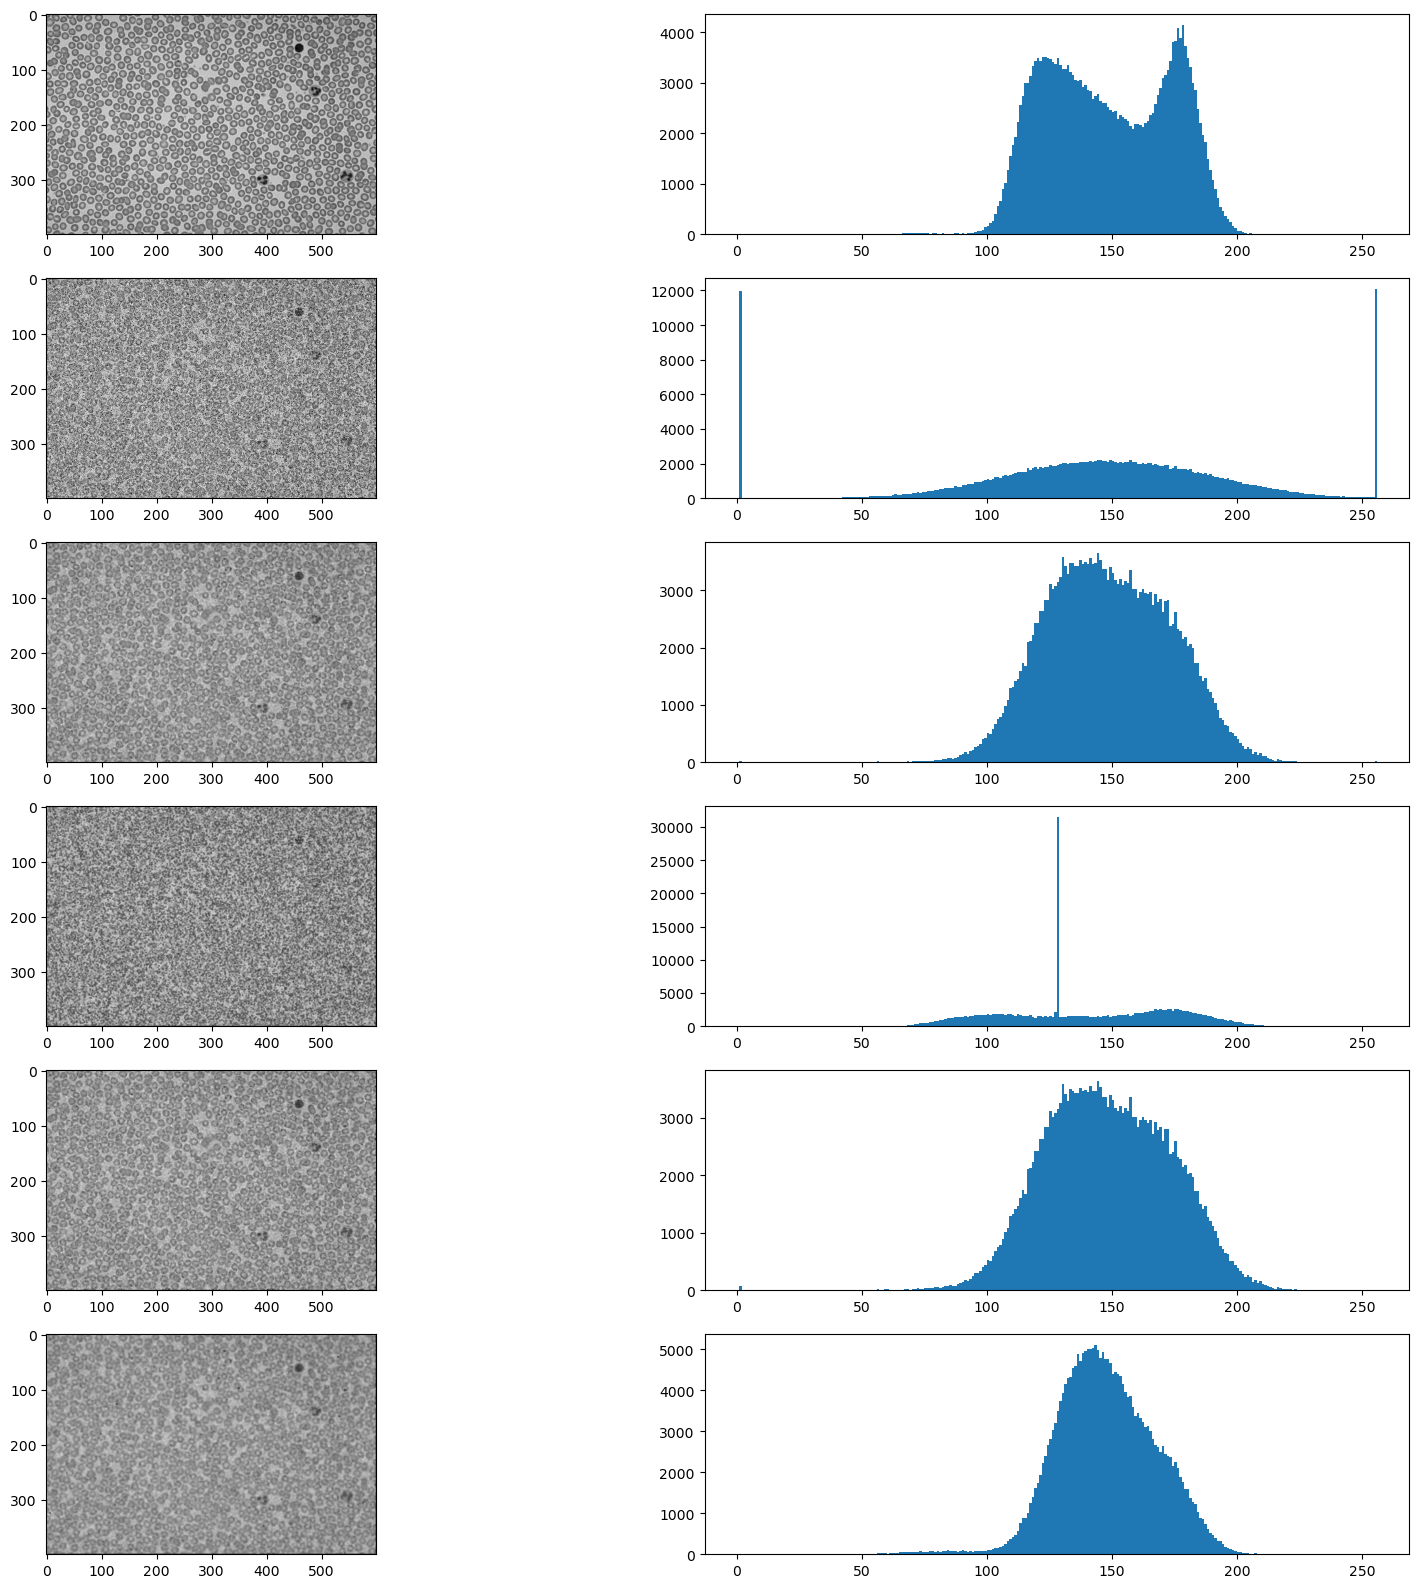

In [7]:

sangre = cv.imread('imagenes/sangre.jpg', cv.IMREAD_GRAYSCALE)
gaussian = np.random.normal(0, 30, (sangre.shape[0],sangre.shape[1])).astype(np.uint8)
imp_noise = impulsivo(1,0.05,255,0.05,0,sangre.shape).astype(np.uint8)

sangre_noise_g = sangre+gaussian
sangre_noise_imp = np.where(imp_noise > 0,imp_noise,sangre_noise_g)

sangre_ptomedio = punto_medio(sangre_noise_imp, 3)
sangre_medalfa = media_alfa(sangre_noise_imp, 3)
sangre_median = cv.medianBlur(sangre_noise_imp , 3)
sangre_medianmedio = punto_medio(sangre_median, 3)


print("MSE Degradada (Gauss+Imp) - Limpia: ",mse(sangre,sangre_noise_imp))
print("MSE Filtrada (Median) - Limpia: ",mse(sangre,sangre_median))
print("MSE Filtrada (PtoMedio) - Limpia: ",mse(sangre,sangre_ptomedio))
print("MSE Filtrada (MediaAlfa) - Limpia: ",mse(sangre,sangre_medalfa))
print("MSE Filtrada (Median + PtoMedio) - Limpia: ",mse(sangre,sangre_medianmedio))




fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,20)) 
ax[0,0].imshow(sangre,cmap='gray')
ax[0,1].hist(sangre.ravel(),256,[0,256])

ax[1,0].imshow(sangre_noise_imp,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(sangre_noise_imp.ravel(),256,[0,256])

ax[2,0].imshow(sangre_median,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(sangre_median.ravel(),256,[0,256])

ax[3,0].imshow(sangre_ptomedio,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(sangre_ptomedio.ravel(),256,[0,256])

ax[4,0].imshow(sangre_medalfa,cmap='gray',vmin=0,vmax=255)
ax[4,1].hist(sangre_medalfa.ravel(),256,[0,256])

ax[5,0].imshow(sangre_medianmedio,cmap='gray',vmin=0,vmax=255)
ax[5,1].hist(sangre_medianmedio.ravel(),256,[0,256])

plt.show()

ejercicio 7

In [8]:
def contrarmonic_filter(image, ksize,Q):

    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape

    ksize = 3
    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)

    im_f_mch = np.zeros(image.shape)
    for i in range(im_H):
        for j in range(im_W):
            im_f_mch[i, j] = np.sum(im_p[i:i+ksize,j:j+ksize]**(Q+1))/(np.sum(im_p[i:i+ksize,j:j+ksize]**Q))

    return im_f_mch

FAMILIA_a = cv.imread('imagenes/FAMILIA_a.jpg', cv.IMREAD_GRAYSCALE)
FAMILIA_b = cv.imread('imagenes/FAMILIA_b.jpg', cv.IMREAD_GRAYSCALE)
FAMILIA_c = cv.imread('imagenes/FAMILIA_c.jpg', cv.IMREAD_GRAYSCALE)

H,W = FAMILIA_a.shape

roia = FAMILIA_a[180:240,1500:1700]
roib = FAMILIA_b[180:240,1500:1700]
roic = FAMILIA_c[180:240,1500:1700]

FAMILIA_a_filtrada= contrarmonic_filter(FAMILIA_a, 3,-1)
FAMILIA_b_filtrada = punto_medio(FAMILIA_b, 3)
FAMILIA_c_filtrada = cv.medianBlur(FAMILIA_c,3)
# fam_butter = filterButterworth(H,W,.04,20)
# fam_butter = np.abs(1-butter)
# FAMILIA_a_filtrada = filterImg(FAMILIA_a,fam_butter)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,20)) 
ax[0,0].imshow(roia,cmap='gray')
ax[0,1].hist(roia.ravel(),256,[0,256])
ax[0,2].imshow(FAMILIA_a_filtrada,cmap='gray')
ax[0,3].hist(FAMILIA_a_filtrada[180:240,1500:1700].ravel(),256,[0,256])

ax[1,0].imshow(roib,cmap='gray')
ax[1,1].hist(roib.ravel(),256,[0,256])
ax[1,2].imshow(FAMILIA_b_filtrada,cmap='gray')
ax[1,3].hist(FAMILIA_b_filtrada[180:240,1500:1700].ravel(),256,[0,256])

ax[2,0].imshow(roic,cmap='gray')
ax[2,1].hist(roic.ravel(),256,[0,256])
ax[2,2].imshow(FAMILIA_c_filtrada,cmap='gray')
ax[2,3].hist(FAMILIA_c_filtrada[180:240,1500:1700].ravel(),256,[0,256])
plt.show()

C:\Users\ignac\AppData\Local\Temp\ipykernel_15628\2674038346.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  im_f_mch[i, j] = np.sum(im_p[i:i+ksize,j:j+ksize]**(Q+1))/(np.sum(im_p[i:i+ksize,j:j+ksize]**Q))


KeyboardInterrupt: 

GUIA 7

Ejercicio 1.5

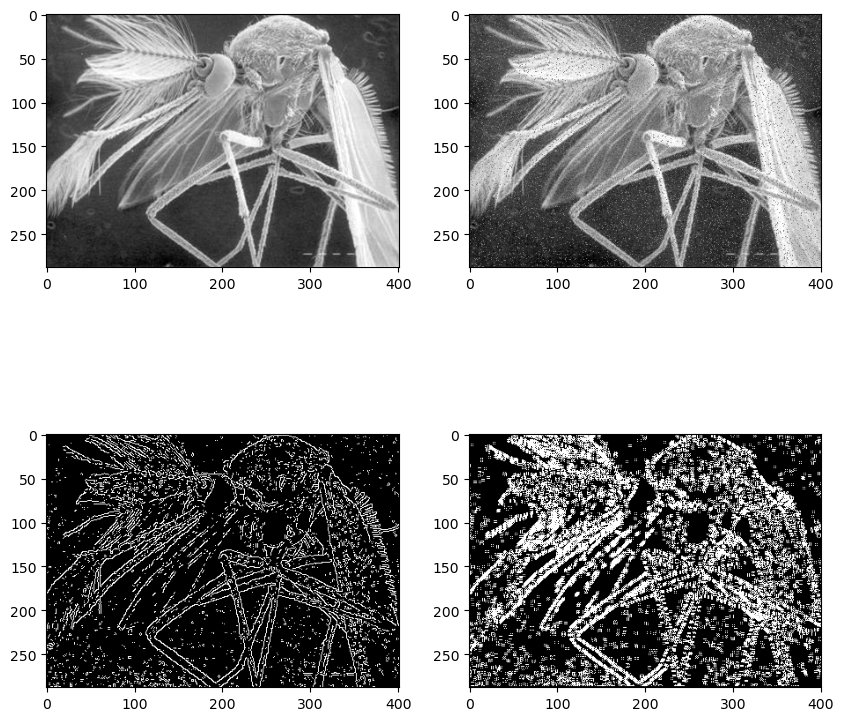

In [9]:
mosquito = cv.imread("imagenes/mosquito.jpg",cv.IMREAD_GRAYSCALE)

#gaussian noise
mosquito_noise = mosquito + np.random.normal(0, 10, (mosquito.shape[0],mosquito.shape[1]))
mosquito_noise = np.clip(mosquito_noise, 0, 255)
mosquito_noise = mosquito_noise.astype(np.uint8)

impulsivo_noise = impulsivo(125,0.055,255,0,0,mosquito_noise.shape).astype(np.uint8)
mosquito_noise = np.where(impulsivo_noise > 0,impulsivo_noise,mosquito_noise)

mosquito_canny = cv.Canny(mosquito_noise,225,250)

mosquito_sobel_x = abs(cv.Sobel(mosquito_canny,cv.CV_64F,1,0,ksize=3))
mosquito_sobel_y = abs(cv.Sobel(mosquito_canny,cv.CV_64F,0,1,ksize=3))
mosquito_sobel_xy = abs(cv.Sobel(mosquito_canny,cv.CV_64F,1,1,ksize=3))


fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10)) 
ax[0,0].imshow(mosquito,cmap="gray",vmin=0,vmax=255)
ax[0,1].imshow(mosquito_noise,cmap="gray",vmin=0,vmax=255)

ax[1,0].imshow(mosquito_canny,cmap='gray',vmin=0,vmax=255)
ax[1,1].imshow(mosquito_sobel_xy,cmap="gray",vmin=0,vmax=255)
plt.show()

como hipotesis el detector que hace uso del laplaciano no lo utilizaremos ya que es muy sencible al ruido. Comparando los distintos ruidos podemos ver que el metodo de canny cuando se utiliza un ruido gausseano resulta util ya que el primer paso de este es pasar un filtro para quitar dicho ruido, mientras que eld etector de sobel o prewitt sufre de este ruido y la imagen detecta bordes gruesos e irregulares. En el caso de el ruido impulsivo unimodal ambos metodos devuelven borden falsos debido al cambio rotundo del nivel de gris, sin embargo si el valor de gris que se utiliza para implementar el ruido unimodal es un gris promedio a la zona del mosquito los borden mejoran pero no mucho. 

Ejercicio 5.3

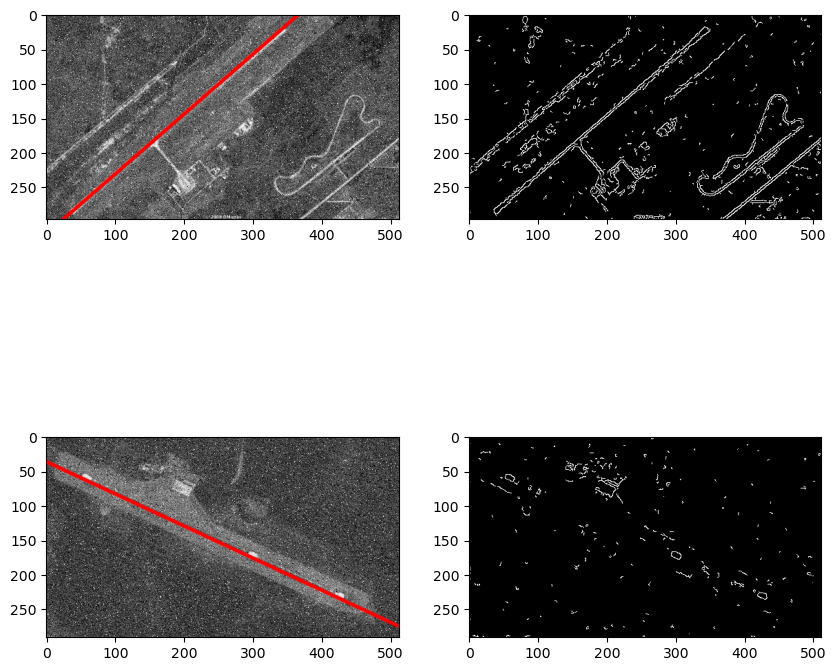

In [10]:
import ipywidgets as widgets
from ipywidgets import interact

aeropuertoCorrientesOgRUIDO = cv.imread("imagenes/corrientes_ruidogris.jpg")
aeropuertoIguazuOgRUIDO = cv.imread("imagenes/iguazu_ruidogris.jpg")
# aeropuertoIguazuOgRUIDO = cv.imread("imagenes/ezeiza1.jpg")

aeropuertoCorrientesOg = cv.imread("imagenes/corrientes.jpg")
aeropuertoIguazuOg = cv.imread("imagenes/iguazu.jpg")


aeropuertoCorrientes = cv.cvtColor(aeropuertoCorrientesOgRUIDO,cv.COLOR_BGR2GRAY)
aeropuertoIguazu = cv.cvtColor(aeropuertoIguazuOgRUIDO,cv.COLOR_BGR2GRAY)


aeropuertoCorrientes=cv.medianBlur(aeropuertoCorrientes,3)
aeropuertoIguazu=cv.medianBlur(aeropuertoIguazu,3)

tresh1=160
tresh2=255

cannyCorrientes = cv.Canny(aeropuertoCorrientes,tresh1,tresh2)
cannyIguazu = cv.Canny(aeropuertoIguazu,tresh1,tresh2)


cdst_iguazu = cv.cvtColor(cannyIguazu, cv.COLOR_GRAY2BGR)
linesP_iguazu = cv.HoughLines(cannyIguazu,1,np.pi/180,1) 
i = 2
while len(linesP_iguazu)!=1:
    linesP_iguazu = cv.HoughLines(cannyIguazu,1,np.pi/180,i)
    i+=1


cdst_corrientes = cv.cvtColor(cannyCorrientes, cv.COLOR_GRAY2BGR)
linesP_corrientes = cv.HoughLines(cannyCorrientes,1,np.pi/180,1) 
i = 2
while len(linesP_corrientes)!=1:
    linesP_corrientes = cv.HoughLines(cannyCorrientes,1,np.pi/180,i)
    i+=1


if linesP_corrientes is not None:
    for line in linesP_corrientes:
        rho,theta = line[0]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        x1 = x0 + 1000*(-b)
        y1 = y0 + 1000*(a)
        x2 = x0 - 1000*(-b)
        y2 = y0 - 1000*(a)

        pt1 = (int(x1), int(y1))
        pt2 = (int(x2), int(y2))
        
        cv.line(aeropuertoCorrientesOgRUIDO, pt1, pt2, (255,0,0), 3, cv.LINE_AA)

if linesP_iguazu is not None:
    for line in linesP_iguazu:
        rho,theta = line[0]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        x1 = x0 + 1000*(-b)
        y1 = y0 + 1000*(a)
        x2 = x0 - 1000*(-b)
        y2 = y0 - 1000*(a)

        pt1 = (int(x1), int(y1))
        pt2 = (int(x2), int(y2))
        
        cv.line(aeropuertoIguazuOgRUIDO, pt1, pt2, (255,0,0), 3, cv.LINE_AA)
    

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10)) 
ax[0,0].imshow(aeropuertoCorrientesOgRUIDO,cmap="gray")
ax[0,1].imshow(cdst_corrientes,cmap="gray")

ax[1,0].imshow(aeropuertoIguazuOgRUIDO,cmap="gray")
ax[1,1].imshow(cdst_iguazu,cmap="gray")
# ax[1,1].hist(aeropuertoIguazu.ravel(),256,[0,256])
plt.show()




# Guia 8

ejercicio 2.3

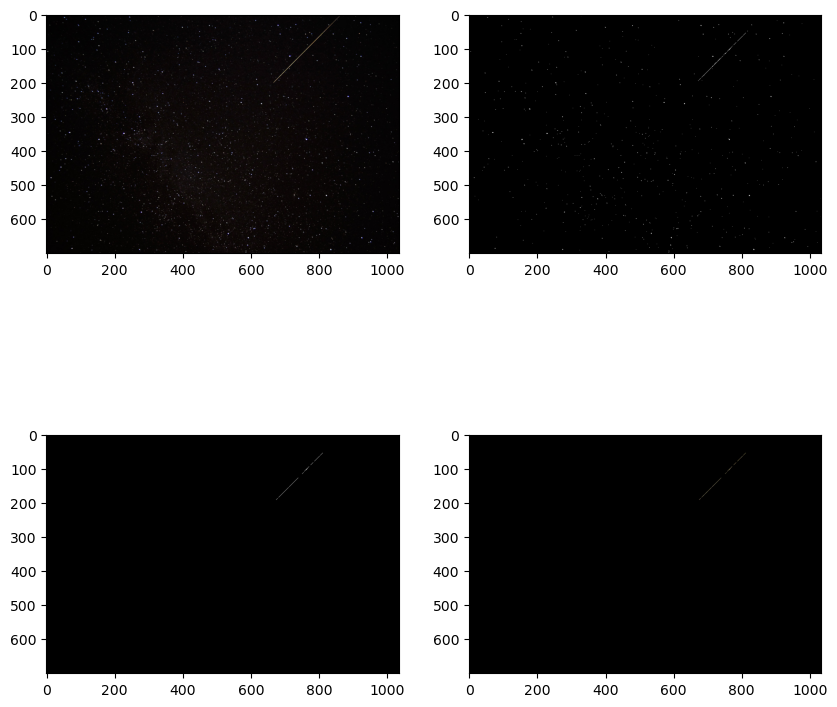

In [35]:
estrellas = cv.imread("imagenes/lluviaEstrellas.jpg")


estrellas_gray = cv.cvtColor(estrellas,cv.COLOR_BGR2GRAY).astype(np.uint8)
_,estrellas_gray = cv.threshold(estrellas_gray,150,255,cv.THRESH_BINARY)

ee = np.array([[0,0,0,0,1],[0,0,0,1,0],[0,0,1,0,0],[0,1,0,0,0],[1,0,0,0,0]]).astype(np.uint8)

estrellas_apertura = cv.morphologyEx(estrellas_gray,cv.MORPH_OPEN,ee)

estrellas_filter = cv.bitwise_and(estrellas,estrellas,mask=estrellas_apertura)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(estrellas[:,:,[2,1,0]],cmap='gray')
ax[0,1].imshow(estrellas_gray,cmap='gray')
ax[1,0].imshow(estrellas_apertura,cmap='gray')
ax[1,1].imshow(estrellas_filter[:,:,[2,1,0]])
plt.show()

ejercicio 5.1

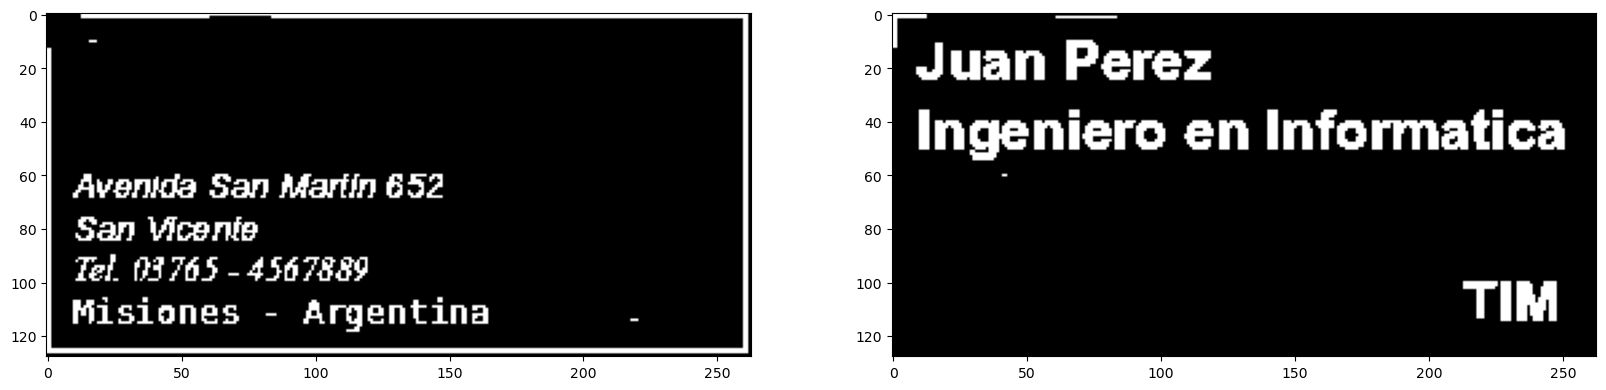

In [36]:
tarjeta = cv.imread("imagenes/Tarjeta.jpeg",cv.IMREAD_GRAYSCALE)
_,tarjeta = cv.threshold(tarjeta,200,255,cv.THRESH_BINARY_INV)


tarjeta_apertura = cv.morphologyEx(tarjeta,cv.MORPH_OPEN,cv.getStructuringElement(cv.MORPH_CROSS,(3,3)),iterations=2)
tarjeta_apertura = cv.morphologyEx(tarjeta_apertura,cv.MORPH_DILATE,cv.getStructuringElement(cv.MORPH_RECT,(6,7)),iterations=3)

mask = cv.bitwise_and(tarjeta,tarjeta,mask=tarjeta_apertura)
mask2 = cv.bitwise_and(tarjeta,tarjeta,mask=255-tarjeta_apertura)
ig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20)) 
ax[0].imshow(mask2,cmap="gray")
ax[1].imshow(mask,cmap="gray")
plt.show()